<a href="https://colab.research.google.com/github/Alligator0-web/-Restaurant-Analysis/blob/main/Restaurant_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import io
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

In [ ]:
pd.set_option("display.max_columns", None)

In [ ]:
order_path = "restaurant_order.csv"
orderitem_path = "restaurant_orderitem.csv"
product_path = "restaurant_product.csv"

orders = pd.read_csv(order_path)
order_items = pd.read_csv(orderitem_path)
products = pd.read_csv(product_path)

print(orders.shape, order_items.shape, products.shape)
orders.head(), order_items.head(), products.head()

(13397, 2) (74818, 4) (248, 3)


(   id             datetime
 0   1  2019-08-03 20:25:00
 1   2  2019-08-03 20:17:00
 2   3  2019-08-03 20:09:00
 3   4  2019-08-03 20:01:00
 4   5  2019-08-03 19:44:00,
    id  quantity  order_id  product_id
 0   1         2         1           6
 1   2         1         1         240
 2   3         1         1          19
 3   4         1         1          36
 4   5         1         1         111,
    id  price           name
 0   1    0.5     Mint Sauce
 1   2    0.5    Lime Pickle
 2   3    0.5  Mango Chutney
 3   4    0.5      Red Sauce
 4   5    0.5  Onion Chutney)

In [ ]:
conn = sqlite3.connect(":memory:")
cur = conn.cursor()

orders.to_sql("restaurant_order", conn, index=False, if_exists="replace")
order_items.to_sql("restaurant_orderitem", conn, index=False, if_exists="replace")
products.to_sql("restaurant_product", conn, index=False, if_exists="replace")

for t in ["restaurant_order", "restaurant_orderitem", "restaurant_product"]:
    cnt = pd.read_sql_query(f"SELECT COUNT(*) AS n FROM {t}", conn)
    print(t, cnt.loc[0, "n"])

restaurant_order 13397
restaurant_orderitem 74818
restaurant_product 248


In [ ]:
sql_merged = """
SELECT
  oi.id             AS orderitem_id,
  oi.quantity       AS quantity,
  oi.order_id       AS order_id,
  oi.product_id     AS product_id,
  p.price           AS unit_price,
  p.name            AS product_name,
  o.datetime        AS order_datetime
FROM restaurant_orderitem AS oi
JOIN restaurant_product  AS p ON oi.product_id = p.id
JOIN restaurant_order    AS o ON oi.order_id   = o.id
"""

merged_df = pd.read_sql_query(sql_merged, conn)
merged_df.shape

(74818, 7)

In [ ]:
merged_path = "restaurant_merged.csv"
merged_df.to_csv(merged_path, index=False)

df = pd.read_csv(merged_path)
print("Форма об'єднаного DataFrame:", df.shape)
df.head()

Форма об'єднаного DataFrame: (74818, 7)


,orderitem_id,quantity,order_id,product_id,unit_price,product_name,order_datetime
0,1,2,1,6,0.80,Plain Papadum,2019-08-03 20:25:00
1,2,1,1,240,12.95,King Prawn Balti,2019-08-03 20:25:00
2,3,1,1,19,2.95,Garlic Naan,2019-08-03 20:25:00
3,4,1,1,36,3.95,Mushroom Rice,2019-08-03 20:25:00
4,5,1,1,111,8.95,Paneer Tikka Masala,2019-08-03 20:25:00


In [ ]:
df["order_datetime"] = pd.to_datetime(df["order_datetime"], errors="coerce")
df["order_hour"] = df["order_datetime"].dt.hour
df["weekday_num"] = df["order_datetime"].dt.weekday
df["weekday_name"] = df["order_datetime"].dt.day_name()

df["item_price"] = df["unit_price"] * df["quantity"]

df.head()

,orderitem_id,quantity,order_id,product_id,unit_price,product_name,order_datetime,order_hour,weekday_num,weekday_name,item_price
0,1,2,1,6,0.80,Plain Papadum,2019-08-03 20:25:00+02:00,20.0,5.0,Saturday,1.60
1,2,1,1,240,12.95,King Prawn Balti,2019-08-03 20:25:00+02:00,20.0,5.0,Saturday,12.95
2,3,1,1,19,2.95,Garlic Naan,2019-08-03 20:25:00+02:00,20.0,5.0,Saturday,2.95
3,4,1,1,36,3.95,Mushroom Rice,2019-08-03 20:25:00+02:00,20.0,5.0,Saturday,3.95
4,5,1,1,111,8.95,Paneer Tikka Masala,2019-08-03 20:25:00+02:00,20.0,5.0,Saturday,8.95


Вилучення даних та об'єднання:
Мета: витягти дані з трьох окремих таблиць та об'єднати їх в один файл формату .csv.
Кроки:
Завантажити дані з трьох таблиць.
Об'єднати дані в один файл та зберегти його у форматі .csv.
Прочитати об'єднаний файл за допомогою бібліотеки pandas, щоб створити єдиний DataFrame.
Перевірка: DataFrame повинен містити 74,818 рядків для підтвердження правильності даних.
Результат: єдиний DataFrame слугуватиме основою для подальшого аналізу та візуалізації в наступних завданнях.

In [ ]:

sql_top_qty = """
SELECT
  p.name AS product_name,
  SUM(oi.quantity) AS total_qty
FROM restaurant_orderitem AS oi
JOIN restaurant_product AS p ON oi.product_id = p.id
GROUP BY p.name
ORDER BY total_qty DESC
LIMIT 10
"""
top_qty = pd.read_sql_query(sql_top_qty, conn)
top_qty


,product_name,total_qty
0,Plain Papadum,10648
1,Pilau Rice,6367
2,Plain Naan,4983
3,Garlic Naan,3318
4,Plain Rice,2964
5,Onion Bhajee,2749
6,Mango Chutney,2504
7,Chicken Tikka Masala,2473
8,Chapati,1935
9,Mint Sauce,1840


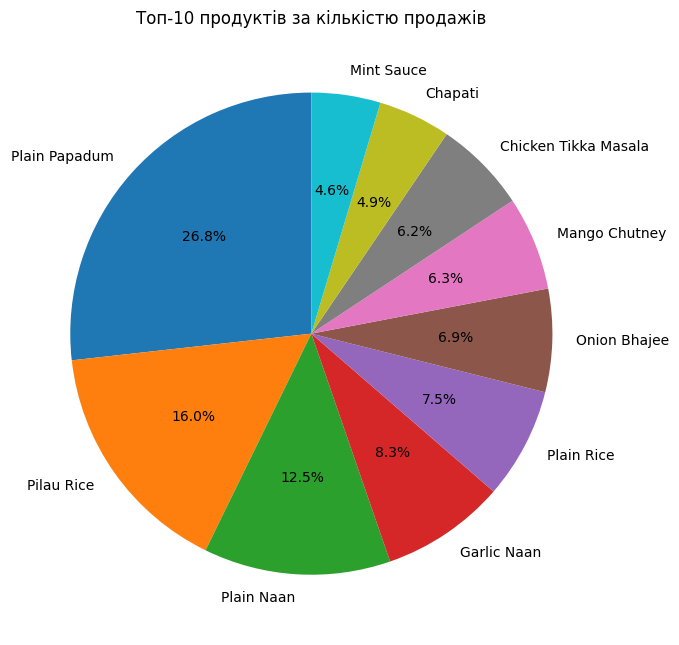

In [ ]:
plt.figure(figsize=(7,7))
plt.pie(top_qty["total_qty"], labels=top_qty["product_name"], autopct="%1.1f%%", startangle=90)
plt.title("Топ-10 продуктів за кількістю продажів")
plt.tight_layout()
plt.show()

Топ-10 найпопулярніших продуктів за кількістю:
Мета: визначити 10 найпопулярніших продуктів ресторану за кількістю проданих одиниць.
Кроки:
Підрахувати, скільки разів кожен продукт був проданий.
Визначити 10 найпопулярніших продуктів на основі кількості проданих одиниць.
Створити кругову діаграму, що відображає відсоткову популярність цих топ-10 продуктів.
Результат: ця діаграма допоможе візуалізувати, які продукти найчастіше купують у ресторані.


In [ ]:

sql_top_rev = """
SELECT
  p.name AS product_name,
  SUM(p.price * oi.quantity) AS revenue
FROM restaurant_orderitem AS oi
JOIN restaurant_product AS p ON oi.product_id = p.id
GROUP BY p.name
ORDER BY revenue DESC
LIMIT 10
"""
top_rev = pd.read_sql_query(sql_top_rev, conn)
top_rev


,product_name,revenue
0,Chicken Tikka Masala,22133.35
1,Pilau Rice,18782.65
2,Plain Naan,12955.80
3,Korma,12261.50
4,Bombay Aloo,10894.45
5,Onion Bhajee,10858.55
6,Butter Chicken,10626.60
7,Garlic Naan,9788.10
8,Korma - Chicken,9764.45
9,Plain Rice,8743.80


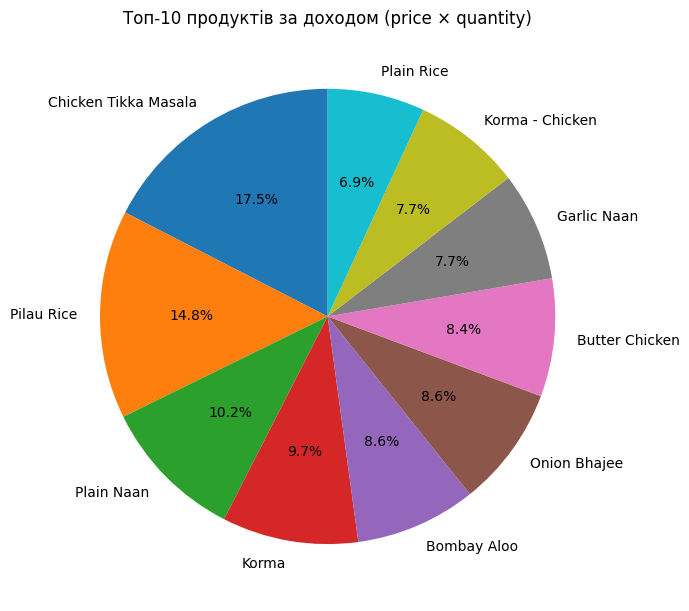

In [ ]:
plt.figure(figsize=(7,7))
plt.pie(top_rev["revenue"], labels=top_rev["product_name"], autopct="%1.1f%%", startangle=90)
plt.title("Топ-10 продуктів за доходом (price × quantity)")
plt.tight_layout()
plt.show()

Аналіз доходу за годинами:
Мета: проаналізувати загальний дохід ресторану залежно від часу, коли були зроблені замовлення.
Кроки:
Виділити годину з поля datetime (значення від 0 до 23).
Підрахувати загальний дохід за кожну годину (сума вартості замовлень).
Створити стовпчикову діаграму, де:
На осі X: Години дня (0-23).
На осі Y: Загальний дохід за кожну годину.
Результат: це дасть уявлення про те, які години є найбільш прибутковими для ресторану, допомагаючи зрозуміти поведінку клієнтів протягом дня.


In [ ]:

sql_rev_by_hour = """
WITH base AS (
  SELECT
    o.datetime AS order_datetime,
    (p.price * oi.quantity) AS item_price
  FROM restaurant_orderitem AS oi
  JOIN restaurant_product  AS p ON oi.product_id = p.id
  JOIN restaurant_order    AS o ON oi.order_id   = o.id
)
SELECT
  CAST(STRFTIME('%H', order_datetime) AS INTEGER) AS order_hour,
  SUM(item_price) AS revenue
FROM base
GROUP BY order_hour
ORDER BY order_hour
"""
rev_by_hour = pd.read_sql_query(sql_rev_by_hour, conn)

full_hours = pd.DataFrame({"order_hour": np.arange(0,24)})
rev_by_hour = full_hours.merge(rev_by_hour, on="order_hour", how="left").fillna({"revenue":0})

rev_by_hour


,order_hour,revenue
0,0,177.95
1,1,54.65
2,2,199.25
3,3,8.90
4,4,63.45
5,5,57.40
6,6,121.60
7,7,0.00
8,8,447.70
9,9,570.60


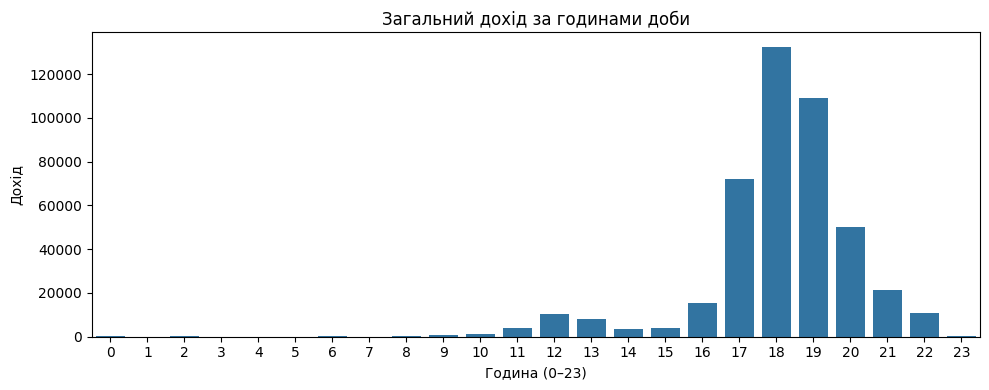

In [ ]:
plt.figure(figsize=(10,4))
sns.barplot(data=rev_by_hour, x="order_hour", y="revenue")
plt.title("Загальний дохід за годинами доби")
plt.xlabel("Година (0–23)")
plt.ylabel("Дохід")
plt.tight_layout()
plt.show()


Аналіз доходу за днями тижня:
Мета: проаналізувати загальний дохід ресторану залежно від дня тижня, коли були зроблені замовлення.
Кроки:
Виділити день тижня з поля datetime (від понеділка до неділі).
Підрахувати загальний дохід за кожен день тижня.
Створити стовпчикову діаграму, де:
На осі X: Дні тижня (від понеділка до неділі).
На осі Y: Загальний дохід за кожен день.
Результат: ця діаграма допоможе визначити, які дні тижня приносять найбільший дохід, що може бути корисним для планування персоналу, акцій чи розкладу.

In [ ]:
weekday_order = [0,1,2,3,4,5,6]
weekday_names = ["Понеділок","Вівторок","Середа","Четвер","П’ятниця","Субота","Неділя"]

rev_by_wd = (
    df.groupby("weekday_num", as_index=False)["item_price"]
      .sum()
      .rename(columns={"item_price":"revenue"})
      .sort_values("weekday_num")
)

rev_by_wd["weekday_name"] = rev_by_wd["weekday_num"].map(dict(zip(weekday_order, weekday_names)))
rev_by_wd = rev_by_wd[["weekday_name","revenue"]]
rev_by_wd


,weekday_name,revenue
0,Понеділок,40008.30
1,Вівторок,38145.65
2,Середа,41246.20
3,Четвер,46021.55
4,П’ятниця,100339.15
5,Субота,112191.65
6,Неділя,67096.00


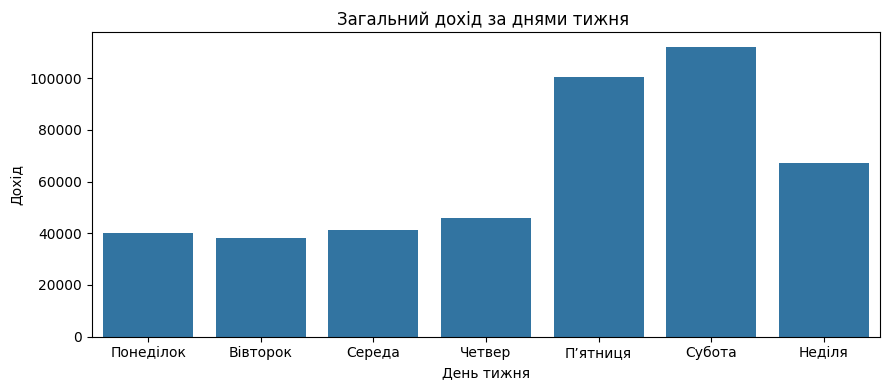

In [ ]:
plt.figure(figsize=(9,4))
sns.barplot(data=rev_by_wd, x="weekday_name", y="revenue", order=weekday_names)
plt.title("Загальний дохід за днями тижня ")
plt.xlabel("День тижня")
plt.ylabel("Дохід")
plt.tight_layout()
plt.show()
